In [6]:
from __future__ import print_function

import pickle
import seaborn as sns
import numpy as np
import pandas as pd
import json
import os
import copy
import time
import tensorflow as tf
import quandl
import matplotlib.pyplot as plt
%matplotlib inline

import sys
import utils

In [7]:
input_list = ['MMM', 'T', 'ABBV', 'ABT', 'ACN', 'AGN', 'ALL', 'GOOGL', 
              'GOOG', 'MO', 'AMZN', 'AXP', 'AIG', 'AMGN', 'AAPL', 'BAC', 'BIIB', 
              'BLK', 'BA', 'BMY', 'CVS', 'COF', 'CAT', 'CELG', 'CVX', 'CSCO', 'C', 
              'KO', 'CL', 'CMCSA', 'COP', 'COST', 'DHR', 'DOW', 'DUK', 'DD', 'EMC', 
              'EMR', 'EXC', 'XOM', 'FB', 'FDX', 'F', 'GD', 'GE', 'GM', 'GILD', 'GS', 'HAL', 
              'HD', 'HON', 'INTC', 'IBM', 'JPM', 'JNJ', 'KMI', 'LLY', 'LMT', 'LOW', 'MA', 
              'MCD', 'MDT', 'MRK', 'MET', 'MSFT', 'MDLZ', 'MON', 'MS', 'NKE', 'OXY', 
              'ORCL', 'PEP', 'PFE', 'PM', 'PG', 'QCOM', 'RTN', 'SLB', 'SPG', 'SO', 'SBUX', 
              'TGT', 'TXN', 'BK', 'PCLN', 'TWX', 'FOXA', 'FOX', 'USB', 'UNP', 'UPS', 'UTX', 
              'UNH', 'VZ', 'V', 'WMT', 'WBA', 'DIS', 'WFC']

In [149]:
print ("Started!!")

st = time.time()
start_date="2015-10-01"
end_date="2016-04-01"
input_data, input_list = utils.get_fixed_data(input_list[:10], start_date=start_date, end_date=end_date) 
sp = quandl.get("YAHOO/INDEX_OEX", start_date=start_date, end_date=end_date)
target_data = np.array(sp['Open'])
elapsed = time.time() - st
print ("time for getting data:", elapsed)

Started!!
('fail_name_list: ', [])
time for getting data: 9.17392611504


In [150]:
# target_data.shape
data = input_data.values

I suceeded to fetch almost all of data(94/100) used for S&P100.

In [27]:
data.shape

(505, 9)

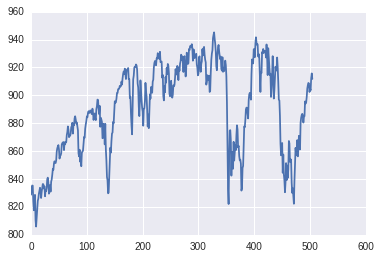

In [18]:
plt.plot(target_data)

# Mutli Scale CNN

In [138]:
import tensorflow as tf
from keras.layers import Dense, Dropout, Activation, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D 
from keras.layers.core import Flatten, Lambda
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers.core import Dense
from keras.engine.topology import Merge
from keras.layers.advanced_activations import PReLU
from keras.layers import SpatialDropout2D
from keras.layers import Dropout
from keras import backend as K
# from keras.layers.core import K
tf.python.control_flow_ops = tf

class MSCNN(object):
    """using multisclae CNN, duplicate indicator"""
    def __init__(self, config):
        self.device = config.device
        self.save_path = config.save_path
        self.is_load = config.is_load
        self.history_length = config.history_length
        self.n_stock = config.n_stock
        self.n_feature = config.n_feature
        self.n_smooth = config.n_smooth
        self.n_down = config.n_down
        self.k_w = config.k_w
        self.n_hidden = config.n_hidden
        self.n_batch = config.n_batch
        self.n_epochs = config.n_epochs
        self.update_rate = config.update_rate
        self.lr = config.learning_rate
        # the actual dimention of input
        # self.n_input = (1 + self.n_smooth + self.n_down) * self.n_stock
        # the length of the data as input
        self.n_history = max(self.n_smooth + self.history_length, (self.n_down + 1) * self.history_length)
        print ("building model....")
        # have compatibility with new tensorflow
        tf.python.control_flow_ops = tf
        # avoid creating _LEARNING_PHASE outside the network
        K.clear_session()
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=False))
        # self.sess = tf.Session()
        K.set_session(self.sess)
        with self.sess.as_default():
            with tf.device(self.device):
                self.build_model()
        print('finished building model!')
        
    def training(self, stock_data, target_data):
        """training multi scale CNN with Adam Optimizer
        
        Args:
            data (list): stock prices for n_stock companies
        """
        T = len(stock_data)
        print_freq = int(T / 10)
        if print_freq == 0:
            print_freq = 1
        print_freq = 10
        print ("training....")
        lr = self.learning_rate
        # assumed that in the first n_history we do nothing
        indices = np.arange(self.n_history - 1, T)
        test_input = [stock_data[t - self.n_history + 1:t + 1] for t in indices]
        test_target = [target_data[t] for t in indices]
        test_current = [stock_data[t] for t in indices]
        for epoch in xrange(self.n_epochs):
            np.random.shuffle(indices)
            batch_indices = [indices[i-self.n_batch:i] for i in np.arange(self.n_batch, T - self.n_batch, self.n_batch)]
            for idx in batch_indices:
                input_value = [stock_data[t - self.n_history + 1:t + 1] for t in idx]
                target_value = [target_data[t] for t in idx]
                current = [stock_data[t] for t in idx]
                # select transition from pool
                self.sess.run(self.optim, 
                              feed_dict={self.state: input_value,
                                         self.target: target_value,
                                         self.learning_rate: self.lr,
                                         self.current_state: current,
                                         K.learning_phase(): 1})  
            if epoch % print_freq == 0:
                print ("epoch:",  epoch)
                # print ("elapsed time", time.time() - st) 
                loss = self.sess.run(self.loss, feed_dict={self.state: test_input,
                                                           self.target: test_target,
                                                           self.current_state: test_current,
                                                           K.learning_phase(): 1})
                print ('loss_train:', loss)
                loss = self.sess.run(self.loss, feed_dict={self.state: test_input,
                                                           self.target: test_target,
                                                           self.current_state: test_current,
                                                          K.learning_phase(): 0})
                print ('loss_test:', loss)
                """                
                output = self.sess.run(self.output,feed_dict={self.input: input_value})
                print ('output:', output.shape)
                print ('target:', target_value.shape)
                """ 
        print ("finished")
        
    def predict(self, data):
        T = len(data)
        predictions = []
        features = []
        currents = []
        for i in range(self.n_history, T + 1):
            features.append(data[i - self.n_history: i])
            currents.append(data[i - 1])
        # output with testmode=0
        prediction = self.sess.run(self.output, feed_dict={self.state: features, 
                                                            self.current_state: currents,
                                                            K.learning_phase(): 0})
        return prediction

    
    def build_model(self):
        """Build all of the network and optimizations
        
        just for conveninece of trainig, seprate placehoder for train and target network
        critic network input: [raw_data, smoothed, downsampled, action]
        actor network input: [raw_data, smoothed, downsampled]
        """
        self.network = self.build_network()
        # transform input into the several scales and smoothing
        self.state =  tf.placeholder(tf.float32, [None, self.n_history, self.n_stock], name='state')
        self.target = tf.placeholder(tf.float32, [None], name='target')
        self.current_state = tf.placeholder(tf.float32, [None, self.n_stock], name='stock')
        # reshape to convolutional input
        state_ = tf.reshape(self.state, [-1, self.n_history, self.n_stock, 1])
        raw, smoothed, down = self.transform_input(state_)
        input_features = [raw,] +  smoothed + down
        network_output = self.network(input_features)
        self.output = tf.reduce_sum(network_output * self.current_state, [1])
        self.loss = tf.reduce_mean((self.output - self.target)**2)
        # optimization
        self.learning_rate = tf.placeholder(tf.float32, shape=[], name="learning_rate")
        self.optim = tf.train.AdamOptimizer(self.learning_rate) \
            .minimize(self.loss)
        tf.initialize_all_variables().run(session=self.sess)
            
        
    def build_network(self):
        """Build critic network
        
        recieve convereted tensor: raw_data, smooted_data, and downsampled_data
        """
        nf = self.n_feature
        # layer1
        # smoothed input
        sm_model = [Sequential() for _ in range(self.n_smooth)]
        for m in sm_model:
            m.add(Lambda(lambda x: x,  input_shape=(self.history_length, self.n_stock, 1)))
            # m.add(SpatialDropout2D(0.2))
            m.add(Convolution2D(nb_filter=nf, nb_row=self.k_w, nb_col=1, border_mode='same'))
            m.add(BatchNormalization(mode=2, axis=-1))
            m.add(PReLU())
        # down sampled input
        dw_model = [Sequential() for _ in range(self.n_down)]
        for m in dw_model:
            m.add(Lambda(lambda x: x,  input_shape=(self.history_length, self.n_stock, 1)))
            # m.add(SpatialDropout2D(0.2))
            m.add(Convolution2D(nb_filter=nf, nb_row=self.k_w, nb_col=1, border_mode='same'))
            m.add(BatchNormalization(mode=2, axis=-1))
            m.add(PReLU())
        # raw input
        state = Sequential()
        nf = self.n_feature
        state.add(Lambda(lambda x: x,  input_shape=(self.history_length, self.n_stock, 1)))
        # state.add(SpatialDropout2D(0.2))
        state.add(Convolution2D(nb_filter=nf, nb_row=self.k_w, nb_col=1, border_mode='same'))
        state.add(BatchNormalization(mode=2, axis=-1))
        state.add(PReLU())
        merged = Merge([state,] + sm_model + dw_model, mode='concat', concat_axis=-1)
        # layer2
        nf = nf * 2
        model = Sequential()
        model.add(merged)
        # merged_state.add(SpatialDropout2D(0.2))
        model.add(Convolution2D(nb_filter=nf, nb_row=self.k_w, nb_col=1, border_mode='same'))
        model.add(BatchNormalization(mode=2, axis=-1))
        model.add(PReLU())
        model.add(Flatten())
        # layer3
        model.add(Dense(self.n_hidden))
        model.add(BatchNormalization(mode=1, axis=-1))
        model.add(PReLU())
        # layer4
        # model.add(Dropout(0.2))
        model.add(Dense(int(np.sqrt(self.n_hidden))))
        # model.add(BatchNormalization(mode=1, axis=-1))
        model.add(PReLU())
        # output
        # model.add(Dropout(0.2))
        model.add(Dense(self.n_stock))
        return model

    
    def transform_input(self, input):
        # the last data is the newest information
        raw = input[:, self.n_history - self.history_length:, :, :]
        # smooth data
        smoothed = []
        for n_sm in range(2, self.n_smooth + 2):
            smoothed.append(
                tf.reduce_mean(tf.pack([input[:, self.n_history - st - self.history_length:self.n_history - st, :, :] for st in range(n_sm)]),0)
            )
        # downsample data
        down = []
        for n_dw in range(2, self.n_down + 2):
            sampled_ = tf.pack([input[:, idx, :, :] for idx in range(self.n_history-n_dw*self.history_length, self.n_history, n_dw)])
            down.append(tf.transpose(sampled_, [1, 0, 2, 3]))
        return raw, smoothed, down
    
    def load(self, checkpoint_dir):
        print(" [*] Reading checkpoints...")
        try:
            self.saver.restore(self.sess, self.save_path)
            return True
        except:
            return False


import numpy as np
target_data = np.zeros((505, 1))
input_data = np.zeros((505, 99))

In [139]:
n_stock = len(data[0])

class MSCNNConfig(object):
    device = '/cpu:0'
    save_path = '/home/tomoaki/work/github/Indicator_Analysis/model.ckpt'
    is_load = False
    activation = 'relu'
    gamma = 0.99
    history_length = 10
    n_stock = n_stock
    n_smooth = 5
    n_down = 5
    k_w = 3
    n_hidden = 100
    n_batch = 32
    n_epochs = 100
    n_feature = 32
    alpha = 0.7
    beta = 0.5
    update_rate = 1e-2
    learning_rate = 1e-3

In [140]:
%%time
import warnings
warnings.filterwarnings("ignore")

config = MSCNNConfig()
mcnn = MSCNN(config)
mcnn.training(data, target_data)

building model....
finished building model!
training....
epoch: 0
loss_train: 48616.8
loss_test: 48616.8
epoch: 10
loss_train: 2386.33
loss_test: 2386.33
epoch: 20
loss_train: 578.259
loss_test: 578.259
epoch: 30
loss_train: 431.387
loss_test: 431.387
epoch: 40
loss_train: 662.094
loss_test: 662.094
epoch: 50
loss_train: 348.223
loss_test: 348.223
epoch: 60
loss_train: 318.678
loss_test: 318.678
epoch: 70
loss_train: 291.837
loss_test: 291.837
epoch: 80
loss_train: 345.441
loss_test: 345.441
epoch: 90
loss_train: 925.846
loss_test: 925.846
finished
CPU times: user 7min 37s, sys: 5.3 s, total: 7min 42s
Wall time: 1min 18s


In [141]:
prediction = mcnn.predict(data)

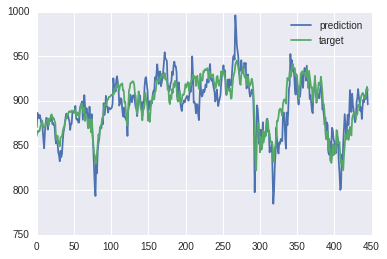

In [142]:
n_data = len(prediction)
plt.plot(prediction, label='prediction')
plt.plot(target_data[-n_data:], label='target')
plt.legend()

In [95]:
print ("Started!!")

st = time.time()
start_date="2016-04-01"
end_date="2016-10-01"
pred_input, input_list = utils.get_fixed_data(input_list[:10], start_date=start_date, end_date=end_date) 
sp = quandl.get("YAHOO/INDEX_OEX", start_date=start_date, end_date=end_date)
pred_target = np.array(sp['Open'])
elapsed = time.time() - st
print ("time for getting data:", elapsed)

Started!!
('fail_name_list: ', [])
time for getting data: 7.7769651413


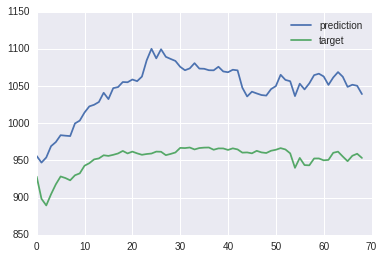

In [143]:
prediction = mcnn.predict(pred_input.values)
n_data = len(prediction)
plt.plot(prediction, label='prediction')
plt.plot(pred_target[-n_data:], label='target')
plt.legend()

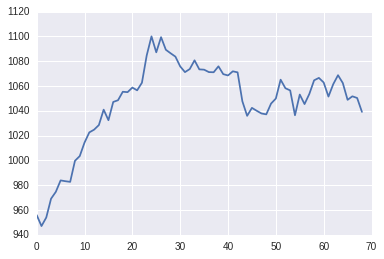

In [144]:
plt.plot(prediction)

In [145]:
import tensorflow as tf
from keras.layers import Dense, Dropout, Activation, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D 
from keras.layers.core import Flatten, Lambda
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers.core import Dense
from keras.engine.topology import Merge
from keras.layers.advanced_activations import PReLU
from keras.layers import SpatialDropout2D
from keras.layers import Dropout
from keras import backend as K
# from keras.layers.core import K
tf.python.control_flow_ops = tf

class MLP(object):
    """using multisclae CNN, duplicate indicator"""
    def __init__(self, config):
        self.device = config.device
        self.save_path = config.save_path
        self.is_load = config.is_load
        self.history_length = config.history_length
        self.n_stock = config.n_stock
        self.n_feature = config.n_feature
        self.n_smooth = config.n_smooth
        self.n_down = config.n_down
        self.k_w = config.k_w
        self.n_hidden = config.n_hidden
        self.n_batch = config.n_batch
        self.n_epochs = config.n_epochs
        self.update_rate = config.update_rate
        self.lr = config.learning_rate
        # the actual dimention of input
        # self.n_input = (1 + self.n_smooth + self.n_down) * self.n_stock
        # the length of the data as input
        self.n_history = max(self.n_smooth + self.history_length, (self.n_down + 1) * self.history_length)
        print ("building model....")
        # have compatibility with new tensorflow
        tf.python.control_flow_ops = tf
        # avoid creating _LEARNING_PHASE outside the network
        K.clear_session()
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=False))
        # self.sess = tf.Session()
        K.set_session(self.sess)
        with self.sess.as_default():
            with tf.device(self.device):
                self.build_model()
        print('finished building model!')
        
    def training(self, stock_data, target_data):
        """training multi scale CNN with Adam Optimizer
        
        Args:
            data (list): stock prices for n_stock companies
        """
        T = len(stock_data)
        print_freq = int(T / 10)
        if print_freq == 0:
            print_freq = 1
        print_freq = 100
        print ("training....")
        lr = self.learning_rate
        # assumed that in the first n_history we do nothing
        indices = np.arange(T)
        test_input = [stock_data[t] for t in indices]
        test_target = [target_data[t] for t in indices]
        for epoch in xrange(self.n_epochs):
            np.random.shuffle(indices)
            batch_indices = [indices[i-self.n_batch:i] for i in np.arange(self.n_batch, T - self.n_batch, self.n_batch)]
            for idx in batch_indices:
                input_value = [stock_data[t] for t in idx]
                target_value = [target_data[t] for t in idx]
                # select transition from pool
                self.sess.run(self.optim, 
                              feed_dict={self.input: input_value,
                                         self.target: target_value,
                                         self.learning_rate: self.lr,
                                         K.learning_phase(): 1})  
            if epoch % print_freq == 0:
                print ("epoch:",  epoch)
                # print ("elapsed time", time.time() - st) 
                loss = self.sess.run(self.loss, feed_dict={self.input: test_input,
                                                           self.target: test_target,
                                                           K.learning_phase(): 1})
                print ('loss_train:', loss)
                loss = self.sess.run(self.loss, feed_dict={self.input: test_input,
                                                           self.target: test_target,
                                                          K.learning_phase(): 0})
                print ('loss_test:', loss)
                """                
                output = self.sess.run(self.output,feed_dict={self.input: input_value})
                print ('output:', output.shape)
                print ('target:', target_value.shape)
                """ 
        print ("finished")
        
    def predict(self, data):
        prediction = self.sess.run(self.output, feed_dict={self.input: data, 
                                                            K.learning_phase(): 0})
        return prediction

    
    def build_model(self):
        """Build all of the network and optimizations
        
        just for conveninece of trainig, seprate placehoder for train and target network
        critic network input: [raw_data, smoothed, downsampled, action]
        actor network input: [raw_data, smoothed, downsampled]
        """
        self.network = self.build_network()
        # transform input into the several scales and smoothing
        self.input =  tf.placeholder(tf.float32, [None, self.n_stock], name='input')
        self.target = tf.placeholder(tf.float32, [None], name='target')
        network_output = self.network(self.input)
        self.output = tf.reduce_sum(network_output * self.input, 1)
        self.loss = tf.reduce_mean((self.output - self.target)**2)
        # optimization
        self.learning_rate = tf.placeholder(tf.float32, shape=[], name="learning_rate")
        self.optim = tf.train.AdamOptimizer(self.learning_rate) \
            .minimize(self.loss)
        tf.initialize_all_variables().run(session=self.sess)
            
        
    def build_network(self):
        """Build critic network
        
        recieve convereted tensor: raw_data, smooted_data, and downsampled_data
        """
        nf = self.n_feature
        # layer1
        # raw input
        model = Sequential()
        nf = self.n_feature
        model.add(Dense(200, input_shape=(self.n_stock,)))
        model.add(BatchNormalization(mode=1, axis=-1))
        model.add(PReLU())
        # layer2
        nf = nf * 2
        model.add(Dense(200, input_shape=(self.n_stock,)))
        model.add(BatchNormalization(mode=1, axis=-1))
        model.add(PReLU())
        # layer3
        model.add(Dense(200))
        model.add(BatchNormalization(mode=1, axis=-1))
        model.add(PReLU())
        # layer4
        # model.add(Dropout(0.5))
        model.add(Dense(100))
        # model.add(BatchNormalization(mode=1, axis=-1))
        model.add(PReLU())
        # output
        # model.add(Dropout(0.5))
        model.add(Dense(self.n_stock))
        return model

    
    def load(self, checkpoint_dir):
        print(" [*] Reading checkpoints...")
        try:
            self.saver.restore(self.sess, self.save_path)
            return True
        except:
            return False


In [157]:
n_stock = len(data[0])

class MSCNNConfig(object):
    device = '/cpu:0'
    save_path = '/home/tomoaki/work/github/Indicator_Analysis/model.ckpt'
    is_load = False
    activation = 'relu'
    gamma = 0.99
    history_length = 10
    n_stock = n_stock
    n_smooth = 5
    n_down = 5
    k_w = 3
    n_hidden = 100
    n_batch = 32
    n_epochs = 10000
    n_feature = 32
    alpha = 0.7
    beta = 0.5
    update_rate = 1e-2
    learning_rate = 1e-2

In [158]:
%%time
import warnings
warnings.filterwarnings("ignore")

config = MSCNNConfig()
mlp = MLP(config)
mlp.training(data, target_data)

building model....
finished building model!
training....
epoch: 0
loss_train: 1.01576e+07
loss_test: 7.8858e+06
epoch: 100
loss_train: 13254.2
loss_test: 5892.88
epoch: 200
loss_train: 4350.56
loss_test: 2908.76
epoch: 300
loss_train: 1855.87
loss_test: 957.012
epoch: 400
loss_train: 809.822
loss_test: 427.327
epoch: 500
loss_train: 528.155
loss_test: 271.548
epoch: 600
loss_train: 334.421
loss_test: 249.004
epoch: 700
loss_train: 393.064
loss_test: 273.897
epoch: 800
loss_train: 245.241
loss_test: 206.441
epoch: 900
loss_train: 270.811
loss_test: 183.252
finished
CPU times: user 27.2 s, sys: 1.4 s, total: 28.6 s
Wall time: 13.4 s


### 

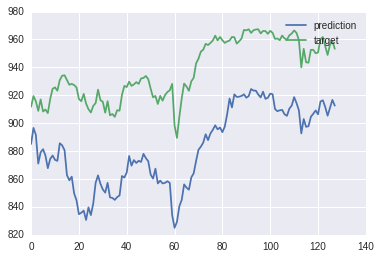

In [154]:
prediction = mlp.predict(pred_input.values)
n_data = len(prediction)
plt.plot(prediction, label='prediction')
plt.plot(pred_target[-n_data:], label='target')
plt.legend()

In [155]:
pred_input.values.shape

(128, 9)

In [156]:
prediction

array([ 885.0982666 ,  896.61523438,  891.61901855,  871.05755615,
        879.14343262,  881.36297607,  876.88049316,  867.77105713,
        874.38153076,  876.84954834,  873.73028564,  872.98828125,
        885.63311768,  884.10235596,  880.63909912,  862.76068115,
        859.05023193,  861.68640137,  849.68896484,  844.75085449,
        834.75488281,  835.81512451,  837.33349609,  830.63653564,
        839.63311768,  834.14703369,  842.46405029,  857.34838867,
        862.60723877,  856.5758667 ,  852.53082275,  850.22363281,
        857.24993896,  846.81994629,  846.42840576,  845.01928711,
        847.03967285,  848.18914795,  862.14678955,  861.06817627,
        864.65466309,  876.5057373 ,  869.5690918 ,  873.54510498,
        871.48345947,  873.0559082 ,  872.23498535,  878.02923584,
        874.97106934,  872.73303223,  863.17443848,  860.28656006,
        867.39904785,  856.81323242,  858.84368896,  856.8104248 ,
        857.23876953,  858.35296631,  857.1661377 ,  834.08532

In [ ]:
class SearchConfig:
    history_length=[8, 64]
    learning_rate=[1e-3, 10]
    leraning_anneal=[3.0e2, 3.0e4]
    n_feature=[18, 1024]
    n_filter=[2, 8]
    n_hidden=[18, 1024]

In [ ]:
import numpy as np

def sample_geo(conf):
    low = conf[0]
    high = conf[1]
    u = np.random.uniform()
    return np.exp((np.log(high / low) * u + np.log(low)))

In [ ]:
def make_train(data, hl):
    return np.array([data[i:i+hl] for i in xrange(len(data) - hl + 1)])

# CNN

Epoch 1/100
244/244 [==============================] - 1s - loss: 3480326.1611     
Epoch 2/100
244/244 [==============================] - 1s - loss: 20716.6102     
Epoch 3/100
244/244 [==============================] - 1s - loss: 9686.0586     
Epoch 4/100
244/244 [==============================] - 1s - loss: 3544.1705     
Epoch 5/100
244/244 [==============================] - 1s - loss: 3400.0593     
Epoch 6/100
244/244 [==============================] - 1s - loss: 3040.4271     
Epoch 7/100
244/244 [==============================] - 1s - loss: 824.5483     
Epoch 8/100
244/244 [==============================] - 1s - loss: 581.4903     
Epoch 9/100
244/244 [==============================] - 1s - loss: 398.6596     
Epoch 10/100
244/244 [==============================] - 1s - loss: 752.8089     
Epoch 11/100
244/244 [==============================] - 1s - loss: 393.9079     
Epoch 12/100
244/244 [==============================] - 1s - loss: 254.8980     
Epoch 13/100
244/244 [=====

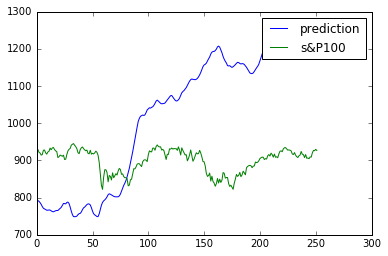

In [139]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, SpatialDropout2D
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import PReLU
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import Adam
import tensorflow as tf
from keras import backend as K

n_stock = input_.shape[1]
# random search
sess = tf.Session()
conf = SearchConfig()
for _ in xrange(1):
    tf.reset_default_graph()
    sess = tf.Session()
    K.set_session(sess)
    model = Sequential()
    hl = int(sample_geo(conf.history_length))
    hl = 10
    # layer1
    k_w, n_feature = int(sample_geo(conf.n_filter)), int(sample_geo(conf.n_feature)) 
    n_feawture=500
    model.add(Convolution2D(nb_filter=n_feature, nb_row=k_w, nb_col=1, border_mode='same', input_shape=(hl, n_stock, 1)))
    model.add(BatchNormalization(mode=0, axis=-1))
    model.add(PReLU())
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # layer2
    k_w, n_feature = int(sample_geo(conf.n_filter)), int(sample_geo(conf.n_feature)) 
    n_feature=1000
    model.add(SpatialDropout2D(0.5))
    model.add(Convolution2D(nb_filter=n_feature, nb_row=k_w, nb_col=1, border_mode='same'))
    # model.add(BatchNormalization(mode=0, axis=-1))
    model.add(PReLU())
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    
    k_w, n_feature = int(sample_geo(conf.n_filter)), int(sample_geo(conf.n_feature)) 
    n_feature=1000
    model.add(SpatialDropout2D(0.5))
    model.add(Convolution2D(nb_filter=n_feature, nb_row=k_w, nb_col=1, border_mode='same'))
    # model.add(BatchNormalization(mode=0, axis=-1))
    model.add(PReLU())
    model.add(Flatten())

    # layer4
    # n_hidden = int(sample_geo(conf.n_hidden))
    n_hidden = 20
    model.add(Dropout(0.5))
    model.add(Dense(n_hidden))
    # model.add(BatchNormalization(mode=1, axis=-1))
    model.add(PReLU())
    # output
    model.add(Dropout(0.5))
    model.add(Dense(1))
        
    lr = sample_geo(conf.learning_rate)
    lr=1e-2
    adm = Adam(lr=lr)
    model.compile(optimizer=adm, loss='mse')
    
    # test_data = make_data(target_data, hl)
    X = make_data(input_.values, hl)
    X = X.reshape(X.shape + (1,))
    Y = target_.values
    test_idx = list(target_.index).index(pd.Timestamp('2015-06-01'))
    train_ = train_data.reshape(train_data.shape + (1,))
    train_X = X[:test_idx - hl + 1]
    test_X = X[test_idx - hl + 1:]
    train_Y = Y[hl-1:test_idx]
    test_Y = Y[test_idx:]
    # training
    model.fit(train_X, train_Y, nb_epoch=100, batch_size=32)
    
    output = model.predict(test_X)

    plt.plot(output, label='prediction')
    plt.plot(test_Y, label='s&P100')
    plt.legend()
    

# MLP

Epoch 1/500
253/253 [==============================] - 0s - loss: 312.0874     
Epoch 2/500
253/253 [==============================] - 0s - loss: 2.0276     
Epoch 3/500
253/253 [==============================] - 0s - loss: 0.4391     
Epoch 4/500
253/253 [==============================] - 0s - loss: 0.3307     
Epoch 5/500
253/253 [==============================] - 0s - loss: 0.1863     
Epoch 6/500
253/253 [==============================] - 0s - loss: 0.0792     
Epoch 7/500
253/253 [==============================] - 0s - loss: 0.0749     
Epoch 8/500
253/253 [==============================] - 0s - loss: 0.0684     
Epoch 9/500
253/253 [==============================] - 0s - loss: 0.0634     
Epoch 10/500
253/253 [==============================] - 0s - loss: 0.0873     
Epoch 11/500
253/253 [==============================] - 0s - loss: 0.1400     
Epoch 12/500
253/253 [==============================] - 0s - loss: 0.1356     
Epoch 13/500
253/253 [==============================] - 0s 

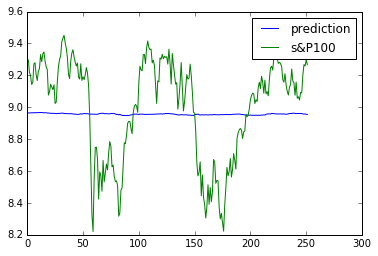

In [131]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, SpatialDropout2D
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import PReLU
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import Adam
import tensorflow as tf
from keras import backend as K

K.set_learning_phase(0)
n_stock = input_.shape[1]
# random search
sess = tf.Session()
conf = SearchConfig()
for _ in xrange(1):
    tf.reset_default_graph()
    sess = tf.Session()
    K.set_session(sess)
    model = Sequential()
    # layer1
    n_hidden = int(sample_geo(conf.n_hidden))
    model.add(Dense(n_hidden, input_dim=n_stock))
    model.add(BatchNormalization(mode=1))
    model.add(PReLU())
    # layer2
    n_hidden = int(sample_geo(conf.n_hidden))
    model.add(Dropout(0.5))
    model.add(Dense(n_hidden))
    model.add(BatchNormalization(mode=1))
    model.add(PReLU())
    
    # layer3
    # n_hidden = int(sample_geo(conf.n_hidden))
    n_hidden = int(sample_geo(conf.n_hidden))
    model.add(Dropout(0.5))
    model.add(Dense(n_hidden))
    # model.add(BatchNormalization(mode=1, axis=-1))
    model.add(PReLU())
    # layer4
    # n_hidden = int(sample_geo(conf.n_hidden))
    n_hidden = int(sample_geo(conf.n_hidden))
    model.add(Dropout(0.5))
    model.add(Dense(n_hidden))
    # model.add(BatchNormalization(mode=1, axis=-1))
    model.add(PReLU())
    # output
    model.add(Dropout(0.5))
    model.add(Dense(1))
        
    lr = sample_geo(conf.learning_rate)
    lr=1e-2
    adm = Adam(lr=lr)
    model.compile(optimizer=adm, loss='mse')
    
    # test_data = make_data(target_data, hl)
    X = input_.values
    Y = target_.values /100
    test_idx = list(target_.index).index(pd.Timestamp('2015-06-01'))
    train_ = train_data.reshape(train_data.shape + (1,))
    train_X = X[:test_idx]
    test_X = X[test_idx:]
    train_Y = Y[:test_idx]
    test_Y = Y[test_idx:]
    # training
    model.fit(train_X, train_Y, nb_epoch=500, batch_size=32)
    
    output = model.predict(test_X)

    plt.plot(output, label='prediction')
    plt.plot(test_Y, label='s&P100')
    plt.legend()
    

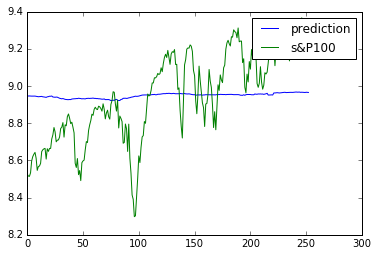

In [133]:
output = model.predict(train_X)

plt.plot(output, label='prediction')
plt.plot(train_Y, label='s&P100')
plt.legend()

# Multi Scale

In [ ]:
uild_critic(self):
        K.set_learning_phase(0)
        # recieve convereted tensor: raw_data, smooted_data, and downsampled_data
        nf = self.n_feature
        # smoothed input
        sm_model = [Sequential() for _ in range(self.n_smooth - 1)]
        for m in sm_model:
            m.add(Convolution2D(nb_filter=nf, nb_row=self.k_w, nb_col=1, border_mode='same', input_shape=(self.history_length, self.n_stock, 1)))
            m.add(BatchNormalization(mode=2, axis=-1))
            m.add(PReLU())
        # down sampled input
        dw_model = [Sequential() for _ in range(self.n_down - 1)]
        for m in dw_model:
            m.add(Convolution2D(nb_filter=nf, nb_row=self.k_w, nb_col=1, border_mode='same', input_shape=(self.history_length, self.n_stock, 1)))
            m.add(BatchNormalization(mode=2, axis=-1))
            m.add(PReLU())
        # raw input
        state = Sequential()
        # layer1
        nf = self.n_feature
        state.add(Convolution2D(nb_filter=nf, nb_row=self.k_w, nb_col=1, border_mode='same', input_shape=(self.history_length, self.n_stock, 1)))
        state.add(BatchNormalization(mode=2, axis=-1))
        state.add(PReLU())
        merged = Merge([state,] + sm_model + dw_model, mode='concat', concat_axis=-1)
        # layer2
        nf = nf * 2
        merged_state = Sequential()
        merged_state.add(merged)
        # model.add(SpatialDropout2D(0.5))
        merged_state.add(Convolution2D(nb_filter=nf, nb_row=self.k_w, nb_col=1, border_mode='same'))
        merged_state.add(BatchNormalization(mode=2, axis=-1))
        merged_state.add(PReLU())
        merged_state.add(Flatten())
        # layer3
        action = Sequential()
        action.add(Lambda(lambda x: x, input_shape=(self.n_stock,)))
        action.add(BatchNormalization(mode=1, axis=-1))
        merged = Merge([merged_state, action], mode='concat')
        model = Sequential()
        model.add(merged)
        model.add(Dense(self.n_hidden))
        model.add(BatchNormalization(mode=1, axis=-1))
        model.add(PReLU())
        # layer4
        # model.add(Dropout(0.5))
        model.add(Dense(int(np.sqrt(self.n_hidden))))
        # model.add(BatchNormalization(mode=1, axis=-1))
        model.add(PReLU())
        # output
        # model.add(Dropout(0.5))
        model.add(Dense(1))
        return model

In [ ]:
import pandas as pd

date_ = pd.to_datetime(date[0])
input_ = pd.DataFrame(input_data[:, :20], index=date)
# input_ = pd.DataFrame(input_data, index=date)
target_ = pd.DataFrame(target_data, index=date_)